# AA-test

Нам необходимо проверить нашу систему спилитирования, исследовав результаты АА-теста, который проводился с 28 марта по 3 аперля 2022г.

Если наша система работает корректно, то мы ожидаем, что статистически значимые различия будут встречаться только в результате случайного ложного срабатывания.

In [111]:
#импортруем необхожимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandahouse
from scipy import stats

sns.set()

In [46]:
#подключение к бд
connection = {
'host': 'https://clickhouse.lab.karpov.courses',
'password': 'password',
'user': 'student',
'database': 'simulator_20220420'
}

In [47]:
#формируем запрос
q = '''SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-03-28' and '2022-04-03'
    and exp_group in (2,3)
GROUP BY exp_group, user_id'''
df = pandahouse.read_clickhouse(q, connection=connection)

In [48]:
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,2,131473,26,148,0.175676
2,3,123580,15,92,0.163043
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667


In [49]:
#посмотрим на число пользователей в каждой группе
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


<AxesSubplot:xlabel='ctr', ylabel='Count'>

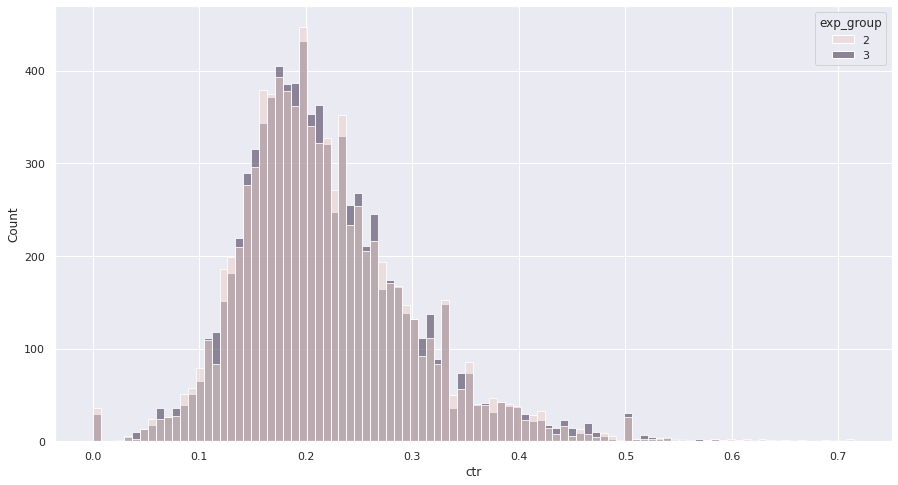

In [50]:
#визуализируем распределение CTR в двух группах
plt.figure(figsize=(15,8))
sns.histplot(data=df, x='ctr', hue='exp_group')

В целом визуально распределения кажутся похожими.

Что будем делать дальше?

Нам необходимо провести симуляцию 10000 АА-тестов. На каждой итерации сформировать подвыборки с повторением в 500 юзеров из 2 и 3 экспериментальной группы и провести сравнение этих подвыборок t-testом, а так же:
- Построить гистограмму распределения получившихся 10000 p-values.
- Посчитать, какой процент p values оказался меньше либо равен 0.05

In [52]:
#в пустой лист будем добавлять получившиеся значения p value
p_values = []
for i in range(10000):
    gr_2 = df.query('exp_group == 2')['ctr'].sample(500, replace=True)
    gr_3 = df.query('exp_group == 3')['ctr'].sample(500, replace=True)
    p_val = stats.ttest_ind(gr_2, gr_3, equal_var=False).pvalue
    p_values.append(p_val)

In [54]:
#преобразуем лист в серию
p_val_series = pd.Series(p_values)

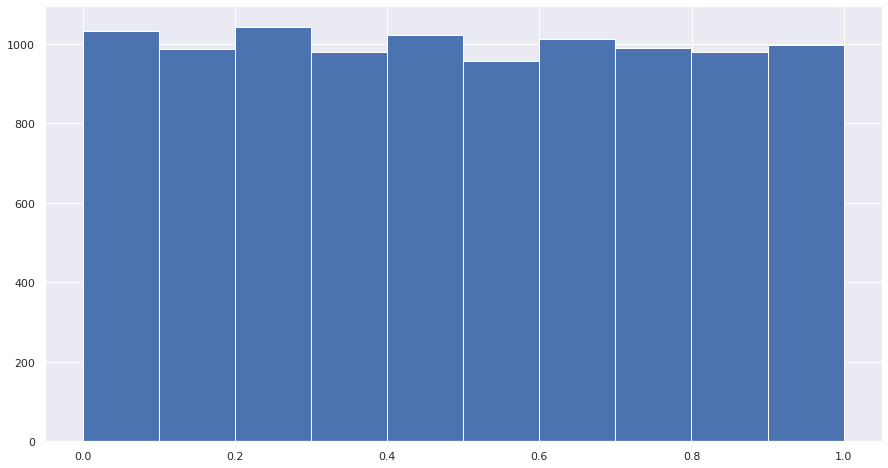

In [102]:
#построим гистограмму получившихся значений
plt.figure(figsize=(15,8))
p_val_series.hist();

Видим, что получившиеся значения p-value в целом равномерно распределены от 0 до 1, следовательно все значения примерно равновероятны.

In [110]:
(p_val_series <= 0.05).mean()

0.0531

А процент p-values меньших либо равных 0.05 почти равен 5% (небольшая погрешность допустима)

Из проведенного исследования мы можем сделать выводы, что:
- как и ожидалось ститистически значимые различия в двух группах обнаруживаются примерно в 5% случаев, если p-value считать равным 0.05;
- следовательно наша система сплитирования работает корректно;